# Sensitivity of flow and APE to $\Delta h_{GL,BBL}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs, read_unparameterized_runs

In [3]:
yp = YAMLParser()

In [4]:
## read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.5deg_N15_KHTH800_vary
nw2_0.5deg_N15_KHGL800_vary_hbbl5
nw2_0.5deg_N15_EBT_KHTH800
nw2_0.5deg_N15_EBT_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl1
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHGL300_hbbl10
nw2_0.25deg_N15_KHGL300_hbbl20
nw2_0.25deg_N15_KHGL300
nw2_0.25deg_N15_KHGL300_hbbldyn
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300_vary
nw2_0.25deg_N15_KHGL300_vary_hbbl5
nw2_0.25deg_N15_EBT_KHTH300
nw2_0.25deg_N15_EBT_KHGL300_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100_vary
nw2_0.125deg_N15_KHGL100_vary_hbbl5
nw2_0.125deg_N15_EBT_KHTH100
nw2_0.125deg_N15_EBT_KHGL100_hbbl5
CPU times: user 13.6 s, sys: 1.83 s, total: 15.5 s
Wall time: 1min 53s


In [5]:
# read unparameterized runs
exps_unparam = yp.read('/glade/u/home/noraloose/GL90paper/config_unparam.yaml')
%time exps_unparam = read_unparameterized_runs(exps_unparam)

CPU times: user 1.24 s, sys: 778 ms, total: 2.02 s
Wall time: 16.3 s


In [6]:
exp_list = [exps_param, exps_unparam]

In [7]:
# compute time average
for exps in exp_list:

    for exp, v in exps.items():
        ds = v['ds']
        dst = ds.mean(dim='time', keep_attrs=True)
        v['dst'] = dst

## Plotting

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

### Zonal flow

In [9]:
def plot_zonal_flow(exps, vmax, lon, lat_range):  
    
    abc_list = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs_flatten = axs.flatten()

    for exp, abc, ax in zip(exps, abc_list, axs.flatten()):
        print(exp['ds'].time[0].values)
        print(len(exp['ds'].time))
        dst = exp['dst']
        st = exp['st']
        label = exp['label']
        grid = exp['grid']

        e = dst.e.compute()
        eta_xy = grid.interp(e, ['X','Y'], boundary='fill').fillna(value=0).compute()
        fld_plot = dst['u'].sel(xq=lon, method="nearest").sel(yh=lat_range).compute()
        lon_exact = dst['u'].xq.sel(xq=lon, method="nearest")

        for i in range(16):
            ax.plot(dst.yq.sel(yq=lat_range), eta_xy.isel(zi=i).sel(xq=lon, method="nearest").sel(yq=lat_range), linewidth=1, color='k')
        p = ax.pcolormesh(
                        dst.yq.sel(yq=lat_range), eta_xy.sel(xq=lon, method="nearest").sel(yq=lat_range), fld_plot,
                        vmax=vmax, vmin=-vmax, cmap='RdBu_r'
        )

        ax.set(title='%s %s' %(abc, label), xlabel=r'Latitude ($^\circ$E)', ylabel='')
        ax.set_yticks(np.arange(-4000, 1, 1000))
        ax.set_yticklabels(np.arange(4000, -1, -1000))
            
    for ax in axs[0,1:]:
        ax.set_yticklabels([])
    for ax in axs[1,1:]:
        ax.set_yticklabels([])
    for ax in axs[2,1:]:
        ax.set_yticklabels([])
    axs[0,0].set(ylabel='Depth (m)')
    axs[1,0].set(ylabel='Depth (m)') 
    axs[2,0].set(ylabel='Depth (m)')  
    axs[2,2].axis('off')

    # colorbar
    fig.subplots_adjust(left=0.1, bottom=0.02)
    cax = fig.add_axes([0.1, -0.1, 0.8, 0.02])
    cb = fig.colorbar(p, cax=cax,extend='both', orientation='horizontal')
    cb.ax.tick_params(labelsize=14)
    cb.set_label(label=r'm s$^{-1}$', labelpad=15)
    
    plt.subplots_adjust(wspace=0.15, hspace=0.4)  
    return fig


In [12]:
exps = [
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20'],
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl1'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl10'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl20'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbldyn']
]
label_list = [
    r'no param',
    r'GM 300',    
    r'GL 300, no $(1-b(\tilde z))$', 
    r'GL 300, $\Delta h_{GL, BBL} = 1$m',  
    r'GL 300, $\Delta h_{GL, BBL} = 5$m',  
    r'GL 300, $\Delta h_{GL, BBL} = 10$m',  
    r'GL 300, $\Delta h_{GL, BBL} = 20$m',
    r'GL 300, $\Delta h_{GL, BBL} = \Delta h_{dynBBL}$'
]

for exp, label in zip(exps, label_list):
    exp['label'] = label


In [13]:
for exp in exps:
    dst = exp['dst']
    with ProgressBar():
        dst['e'].load()
        dst['u'].load()

[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 42.7s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 44.3s
[########################################] | 100% Completed | 52.0s
[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 48.2s
[########################################] | 100% Completed | 43.2s
[########################################] | 100% Completed | 52.6s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 44.0s
[########################################] | 100% Completed | 52.7s
[########################################] | 100% Completed | 44.6s
[########################################] | 100

30002.5
400
75002.5
400
75002.5
400
75002.5
400
75002.5
400
75002.5
400
75002.5
400
75002.5
400


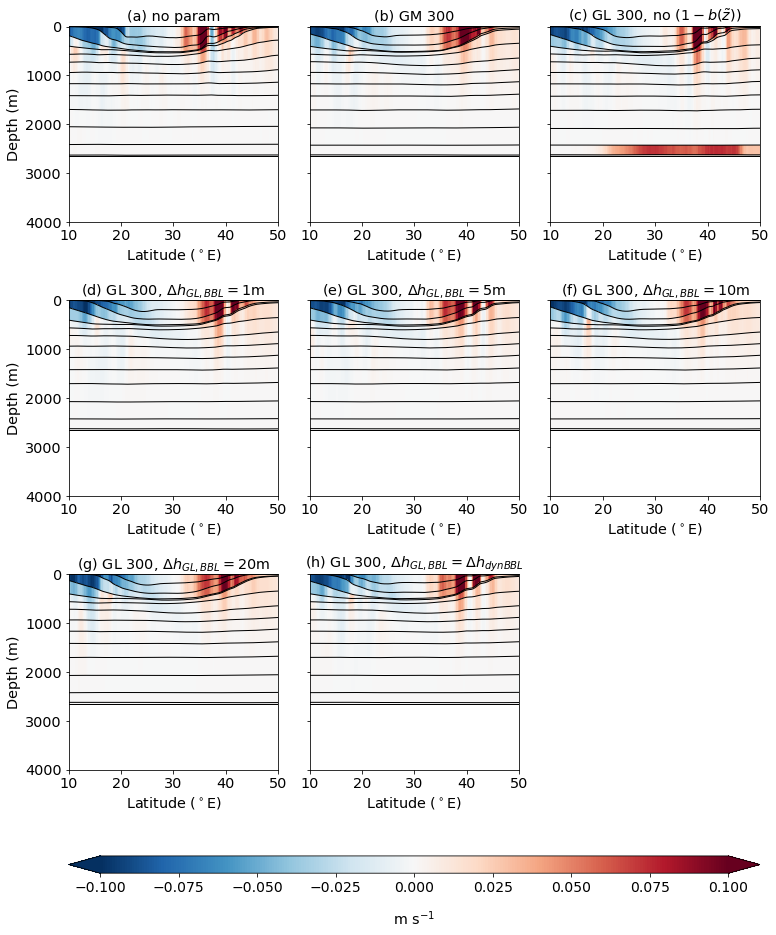

In [14]:
vmax = 0.1
lat_range = slice(10, 50)
lon = 4

fig = plot_zonal_flow(exps, vmax, lon, lat_range)
figname = '/glade/u/home/noraloose/GL90paper/figures/flow_sensitivity.png' 
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

In [15]:
from cycler import cycler

def plot_APE_with_zoom(exps):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    cyc = cycler(color=['k', '#66a61e', '#e6ab02', '#d7b5d8', '#df65b0', '#dd1c77', '#980043',  '#1f78b4'])
    
    ax.set_prop_cycle( cyc )
    
    for exp in exps:
        os = exp['os']
        label = exp['label']
        ax.plot(os.Time.sel(Time=slice(None, 77000)), os.APE.sum(dim='Interface').sel(Time=slice(None, 77000)), label=label, linewidth=3)
                   
    # inset axes....
    axins = ax.inset_axes([0.3, 0.1, 0.65, 0.57])
    axins.set_prop_cycle( cyc )
    for exp in exps:
        os = exp['os']
        ds = exp['ds']
        label = exp['label']
        axins.plot(os.Time.sel(Time=slice(35000, 77000)), os.APE.sum(dim='Interface').sel(Time=slice(35000, 77000)), label='_none', linewidth=3)
    axins.grid()
    axins.ticklabel_format(useMathText=True)


    ax.ticklabel_format(useMathText=True)
    ax.indicate_inset_zoom(axins, edgecolor="black")    
    ax.set(ylabel = 'Joules', xlabel = 'Time (days)', title='Available Potential Energy')
    legend = ax.legend(bbox_to_anchor=(0.5, -0.3), loc="center", fontsize=16, ncol=3)

    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    maxtime = 77000
    ax.axvspan(maxtime-2000, maxtime, facecolor='0.1', alpha=0.2)
    ax.axvspan(maxtime-2000, maxtime, facecolor='0.1', alpha=0.2)

    intertime = 32000
    ax.axvspan(intertime-2000, intertime, facecolor='0.1', alpha=0.2)
    ax.axvspan(intertime-2000, intertime, facecolor='0.1', alpha=0.2)

    return fig

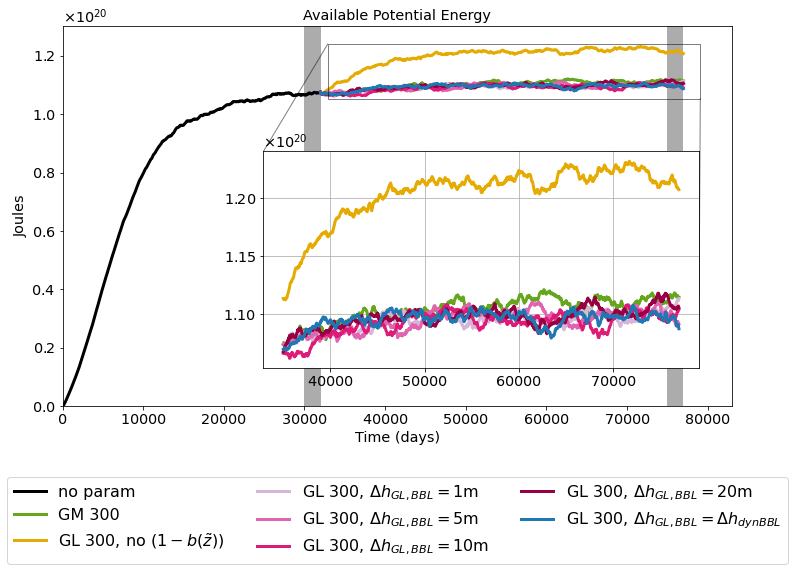

In [16]:
fig = plot_APE_with_zoom(exps)
figname = '/glade/u/home/noraloose/GL90paper/figures/APE_sensitivity.png' 
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)